# Dark matter electron scattering

In [1]:
import numericalunits as nu
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import wimprates as wr

## Ionization form factors

The dashed white line shows $q = \sqrt{2 m_e (E_b + E_R)}$, with $E_b$ the binding energy and $E_R$ the recoil energy. This is approximately where the form factor is strongest; if I'm not mistaken this is the $q$ for an initially stationary electron.

Red contours show the kinematically allowed region -- that is, where the minimum required DM velocity is less than the maximum DM velocity under the standard halo model -- for:
  * $m_\chi = 10 \mathrm{MeV}/c^2$ (solid)
  * $m_\chi = 100 \mathrm{MeV}/c^2$ (dashed)
  * $m_\chi = 1000 \mathrm{MeV}/c^2$ (dotted)
  
Notice the provided form factors do not cover the entire allowed region for higher masses, although much of the region that isn't covered should be massively suppressed (since it's far from the white line). For $E_R \gtrapprox 200 \mathrm{eV}$ however, some relevant data for especially the inner shells is missing. We will assume the form factors are zero there, which should lead to conservative rates.

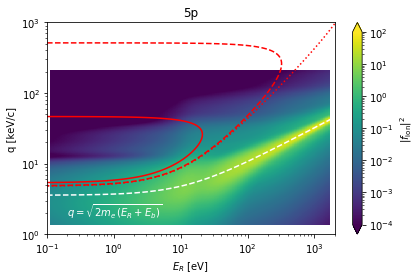

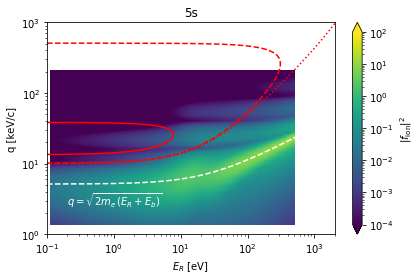

/home/jelle/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


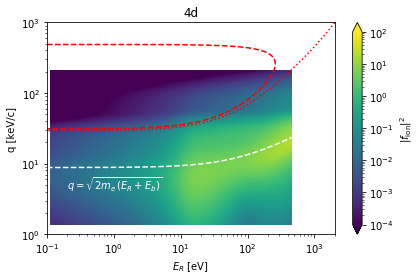

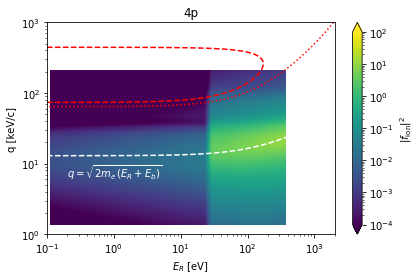

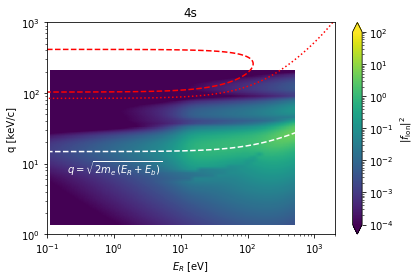

In [2]:
e_er = np.geomspace(.1, 2000, 400)
q = np.geomspace(1, 1000, 400)

grid_e, grid_q = np.meshgrid(e_er, q)

for shell in wr.dme_shells:
    ff2 = wr.dme_ionization_ff(
        shell,
        grid_e.ravel() * nu.eV,
        grid_q.ravel() * nu.keV / nu.c0).reshape(grid_e.shape)

    plt.pcolormesh(grid_e, grid_q, ff2, 
                   norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e2),
                   cmap=plt.cm.viridis)
    plt.colorbar(extend='both', label='$|f_\mathrm{ion}|^2$')
    
    eb = wr.binding_es_for_dme(*shell)
    y = (2 * nu.me * (e_er * nu.eV + eb))**0.5 / (nu.keV/nu.c0)
    plt.plot(e_er, y,
             color='w', linestyle='--')
    plt.text(0.2, 0.5 * y[np.argmin(np.abs(e_er - 0.2))],
             "$q = \sqrt{2 m_e \, (E_R + E_b)}$", color='w')
    
    for m, linestyle in zip([10, 100, 1000], ['-', '--', ':']):
        plt.contour(
            grid_e, grid_q, 
            wr.v_min_dme(eb, grid_e * nu.eV, grid_q * nu.keV/nu.c0, 
                         mw=m * nu.MeV/nu.c0**2),
            levels=[wr.v_max()], colors=['r'], linestyles=[linestyle])

    plt.xscale('log')
    plt.xlabel("$E_R$ [eV]")

    plt.yscale('log')
    plt.ylim(1, 1000)
    plt.ylabel("q [keV/c]")

    shell = wr.shell_str(*shell)
    plt.title(shell)
    plt.tight_layout()
    plt.savefig('form_factor_%s.png' % shell, dpi=200, bbox_inches='tight')
    plt.show()

## Differential rates vs. energy

(1e-10, 0.0001)

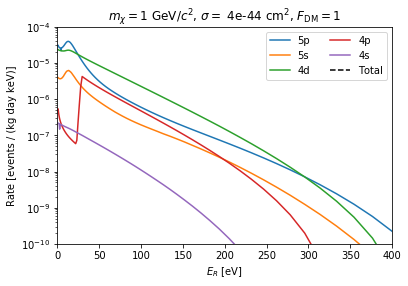

In [3]:
e_er = np.geomspace(1, 400, 100)
m_gev = 1
s_cm2 = 4e-44

drs = dict()
for n, l in wr.dme_shells:
    drs[wr.shell_str(n,l)] = dr = wr.rate_dme(
        e_er * nu.eV, 
        n, l, 
        mw=m_gev * nu.GeV/nu.c0**2, 
        sigma_dme=s_cm2 * nu.cm**2)
    
    plt.plot(e_er, dr * (nu.kg * nu.keV * nu.day),
             label=wr.shell_str(n, l))
    
plt.plot(e_er, np.sum(list(drs.values()), axis=0),
         label='Total', c='k', linestyle='--')

title = "$m_\chi = %s$ $\mathrm{GeV}/c^2$, $\sigma =$ %s $\mathrm{cm}^2$, $F_\mathrm{DM} = 1$" % (m_gev, s_cm2)
plt.title(title)
plt.legend(loc='upper right', ncol=2)

plt.xlabel("$E_R$ [eV]")
plt.xlim(0, 400)

plt.yscale('log')
plt.ylabel("Rate [events / (kg day keV)]")
plt.ylim(1e-10, 1e-4)

## Rates vs n_electrons

In [4]:
from scipy.stats import binom

additional_quanta = {
    '4s': 3,
    '4p': 6,
    '4d': 4,
    '5s': 0,
    '5p': 0
}


def rates_to_ne(e_er, drs,
                W=None, max_n_el=16,
                p_primary=1, p_secondary=0.83,
                swap_4s4p=False):
    """Return (n_electrons, {shell: rate / (kg day) for each electron count})
    
    :param W: Work function (energy need to produce a quantum)
    :param max_n_el: Maximum number of electrons to consider.
    :param p_primary: Probability that primary electron survives
    :param p_secondary: Probability that secondary quanta survive as electrons
    :param swap_4s4p: If True, swap differential rates of 4s and 4p
    """
    if W is None:
        W = 13.8 * nu.eV
        
    n_el = np.arange(max_n_el + 1, dtype=np.int)
    result = dict()    
    
    # We need an "energy bin size" to multiply with (or do some fancy integration)
    # I'll use the differences between the points at which the differential 
    # rates were computed.
    # To ensure this doesn't give a bias, nearby bins can't differ too much 
    # (e.g. use a linspace or a high-n logspace/geomspace)
    binsizes = np.array(np.diff(e_er).tolist() + [e_er[-1] - e_er[-2]])
    
    for shell, rates in drs.items():
        if swap_4s4p:
            # Somehow we can reproduce 1703.00910
            # if we swap 4s <-> 4p here??
            if shell == '4s':
                rates = drs['4p']
            elif shell == '4p':
                rates = drs['4s']

        # Convert to from energy to n_electrons
        r_n = np.zeros(len(n_el))
        for e, r in zip(e_er, rates * binsizes):
            n_secondary = int(np.floor(e / W)) + additional_quanta[shell]
            r_n += r * (
                p_primary * binom.pmf(n_el - 1, n=n_secondary, p=p_secondary)
                + (1 - p_primary) * binom.pmf(n_el, n=n_secondary, p=p_secondary))

        # We can't see "0-electron events"
        # Set their rate to 0 so we don't sum them accidentally
        r_n[0] = 0
        
        result[shell] = r_n
        
    return n_el, result

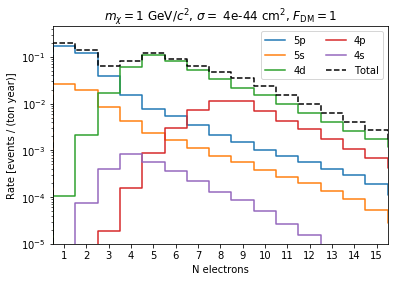

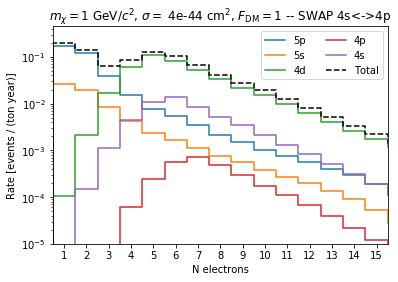

In [5]:
for do_swap in (False, True):
    n_el, drsn = rates_to_ne(e_er * nu.eV, drs, 
                             swap_4s4p=do_swap)
    
    for shell, rn in drsn.items():
        rn *= (1000 * nu.kg * nu.year)
        plt.plot(n_el, rn, drawstyle='steps-mid', label=shell)

    plt.plot(n_el, np.sum(list(drsn.values()), axis=0),
             label='Total',
             drawstyle='steps-mid', 
             linestyle='--', 
             c='k')

    plt.title(title + (' -- SWAP 4s<->4p' if do_swap else ''))
    plt.legend(loc='upper right', ncol=2)

    plt.xticks(np.arange(1, 16))
    plt.xlim(0.5, 15.5)
    plt.xlabel("N electrons")

    plt.yscale('log')
    plt.ylim(1e-5, .45)
    plt.ylabel("Rate [events / (ton year)]")
    
    plt.show()